In [3]:
import pandas as pd
import numpy as np
import sklearn.decomposition
from scipy import stats
import os
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
import tissue_enrichment_analysis as tea
import morgan as morgan
import networkx as nx
import genpy

ft = 35 #title fontsize


single_mutants = ['b', 'c', 'd', 'e', 'g']
double_mutants = {'a' : 'bd', 'f':'bc'}

thomas = morgan.hunt('target_id', 'b', 'tpm', 'qval')
thomas.add_genmap('../input/library_genotype_mapping.txt', comment='#')
thomas.add_single_mutant(single_mutants)
thomas.add_double_mutants(['a', 'f'], ['bd', 'bc'])
thomas.set_qval()

# Add the tpm files: 
kallisto_loc = '../input/kallisto_all/'
thomas.add_tpm(kallisto_loc, '/kallisto/abundance.tsv', '')

# Make all possible combinations of WT, X
combs = {}
for gene in thomas.genmap.genotype.unique():
    if gene != 'wt':
        combs[gene] = 'WT_'+gene+'/'

# load all the beta values for each genotype:
sleuth_loc = '../sleuth/'
thomas.add_betas(sleuth_loc, 'betas.csv', combs)

thomas.filter_data(0, 0.1)
fast = morgan.brenner('single_mutant_analysis', thomas)
bayes = morgan.mcclintock('single_mutant_analysis', thomas)


Number of na genes: 1370


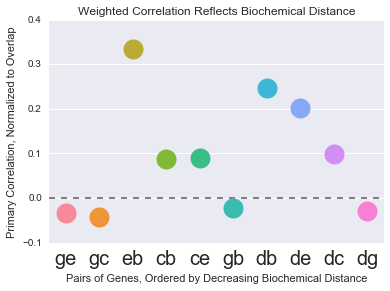

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

df = pd.melt(bayes.robust_slope, id_vars='corr_with', var_name='genotype', value_name='slope')
df['pair'] = df.genotype + df.corr_with
df = df[df.slope.abs() > 0]

sort_pairs = {'be': 1,
              'ed': 2,
              'ec': 3,
              'ge': 4,
              'bd': 5,
              'bc': 6,
              'bg': 7,
              'cd': 8,
              'gd': 9,
              'gc': 10
             }
def sorted_pairs(x):
    key = x.pair
    if key in sort_pairs.keys():
        return sort_pairs[key]
    else:
        return np.nan

df['sort_pairs'] = df.apply(sorted_pairs, axis=1)
df.sort('sort_pairs', inplace=True)
sns.stripplot(x='pair', y='slope', data=df[df.slope.abs() > 0], size=20)
plt.xticks(fontsize=20)
# plt.ylim()
# plt.yticks([0, 0.5, 1], fontsize=20)
plt.axhline(0, lw=2, ls='--', color='gray')
plt.xlabel('Pairs of Genes, Ordered by Decreasing Biochemical Distance')
plt.ylabel('Primary Correlation, Normalized to Overlap')
plt.title('Weighted Correlation Reflects Biochemical Distance')
plt.savefig('../output/weighted_corr_decreases_w_distance.pdf')

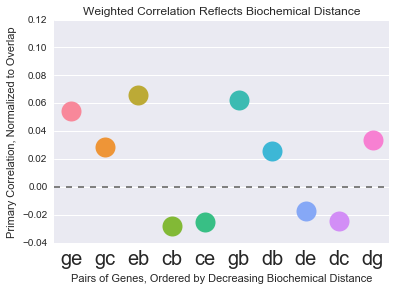

In [3]:
bayes.secondary_slope['corr_with'] = thomas.single_mutants
df2 = pd.melt(bayes.secondary_slope, id_vars='corr_with', var_name='genotype', value_name='slope')
df2['pair'] = df2.genotype + df2.corr_with
df2 = df2[df2.slope.abs() > 0]

sort_pairs = {'be': 1,
              'ed': 2,
              'ec': 3,
              'ge': 4,
              'bd': 5,
              'bc': 6,
              'bg': 7,
              'cd': 8,
              'gd': 9,
              'gc': 10
             }
def sorted_pairs(x):
    key = x.pair
    if key in sort_pairs.keys():
        return sort_pairs[key]
    else:
        return np.nan

df2['sort_pairs'] = df2.apply(sorted_pairs, axis=1)
# d.head()
df2.sort('sort_pairs', inplace=True)
sns.stripplot(x='pair', y='slope', data=df2, size=20)
plt.xticks(fontsize=20)
# plt.ylim()
# plt.yticks([0, 0.5, 1], fontsize=20)
plt.axhline(0, lw=2, ls='--', color='gray')
plt.xlabel('Pairs of Genes, Ordered by Decreasing Biochemical Distance')
plt.ylabel('Primary Correlation, Normalized to Overlap')
plt.title('Weighted Correlation Reflects Biochemical Distance')


In [4]:
alfred = morgan.sturtevant('epistasis_analysis')

In [5]:
alfred.epistasis_analysis(thomas)

Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.6 sec
0.086
Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.8 sec
0.08
Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.5 sec
0.067
Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 2.0 sec
-0.00063
Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.6 sec
0.11
Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 2.4 sec
0.31
Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-

In [17]:
def normalize(x):
    pair = thomas.double_muts[x.double_mutant]
    if pair in  df.pair.unique():
        return x.correlation/df[df.pair==pair].slope.values[0]
    pair = pair[1] + pair[0]
    if pair in df.pair.unique():
        return x.correlation/df[df.pair==pair].slope.values[0]
    else:
        return np.nan

alfred.epistasis['norm_corr'] = alfred.epistasis.apply(normalize, axis=1)


f bc
a bd


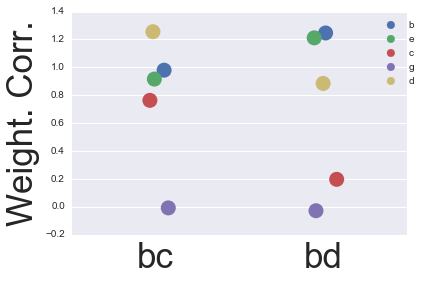

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
sns.stripplot(x='double_mutant', y='norm_corr', hue='corr_with', data=alfred.epistasis, size=15, jitter=True)
plt.legend(bbox_to_anchor= (1.05, 1), fontsize=25)

ax = plt.gca()

xlabels = []
for c in thomas.double_muts.keys():
    print(c, thomas.double_muts[c])
    xlabels += [thomas.double_muts[c]]

# x = np.linspace(0, len(ax.get_xticklabels())-1, len(ax.get_xticklabels()))
# plt.xlabels(fontsize=20*ft)
# plt.yticks([0, 0.5, 1], fontsize=ft/2)
plt.ylabel('Weight. Corr.', fontsize=35)
plt.gca().set_xticklabels(xlabels, fontsize=ft)
plt.xlabel('')
plt.legend(bbox_to_anchor= (1.05, 1))

In [70]:
def entropy(p):
    return -p*np.log2(p) - (1-p)*np.log2(1-p)

def find_entropy(letter):
    x = thomas.beta_filtered[letter]
    p = len(x[x.qval<0.1])/len(x)

    return entropy(p)

In [53]:
entropyBC = find_entropy('f')
entropyB = find_entropy('b')

In [140]:
def find_entropy_x_given_y(letter1, letter2):
    x = thomas.beta_filtered[letter1]
    y = thomas.beta_filtered[letter2]
    
    ysig = y[y.qval < 0.1]
    xsig = x[x.qval < 0.1]
    
    # find overlap
    ovx = xsig[xsig.target_id.isin(ysig.target_id)]
    ovy = ysig[ysig.target_id.isin(ovx.target_id)]
    
    # calculate cond prob:
    p_XgY = len(ovy)/len(x)
    return entropy(p_XgY)

In [121]:
maxMval = 0
maxM = ''
minMval = 1000
minM = ''
prevM = 0
ent = find_entropy('a')
for mutant in thomas.single_mutants:
    M = ent - find_entropy_x_given_y('a',`if M > maxMval:
        maxMval = M
        maxM = mutant
    if M < minMval:
        minMval = M
        minM = mutant


In [169]:
vals = np.array([])
for mutant in thomas.single_mutants:
    df = thomas.beta_filtered[mutant]
    size = len(df[df.qval < 0.1])
    if len(vals) > 0:
        vals = np.concatenate([vals, [size]])
    else:
        vals = np.array([size])
vals2 = np.array([])
for mutant in thomas.double_muts.keys():
    df = thomas.beta_filtered[mutant]
    size = len(df[df.qval < 0.1])
    if len(vals2) > 0:
        vals2 = np.concatenate([vals2, [size]])
    else:
        vals2 = np.array([size])

In [170]:
import seaborn as sns

([<matplotlib.axis.XTick at 0x17ed87eb8>,
 <a list of 3 Text xticklabel objects>)

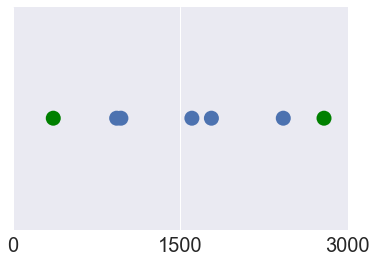

In [179]:
sns.stripplot(vals, size=15)
sns.stripplot(vals2, size=15, color='g')
plt.xticks([0, 1500, 3000], fontsize=20)

In [9]:
df = thomas.beta_filtered['b']
size = len(df[df.qval < 0.1])


In [10]:
df2 = thomas.beta_filtered['a']


In [11]:
df2['compare'] = df2.b/df.b

# bd double compared to b single

In [20]:
hif = thomas.beta_filtered['c']
hif = hif[hif.qval < 0.1].target_id
df = thomas.beta_filtered['b']
df = df[df.target_id.isin(hif)].copy()
df2 = thomas.beta_filtered['a']
df2 = df2[df2.target_id.isin(hif)].copy()
df2['compare'] = df2.b/df.b
df2[(df2.qval < 0.1)].compare.abs().mean()

4.628165515988157

# bd double compared to d single

In [21]:
hif = thomas.beta_filtered['c']
hif = hif[hif.qval < 0.1].target_id
df = thomas.beta_filtered['d']
df = df[df.target_id.isin(hif)].copy()
df2 = thomas.beta_filtered['a']
df2 = df2[df2.target_id.isin(hif)].copy()
df2['compare'] = df2.b/df.b
df2[(df2.qval < 0.1)].compare.abs().mean()

6.437825167583539

# bc double compared to c single

bayes.